Found 2647 images belonging to 2 classes.
Found 660 images belonging to 2 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 22s 22s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 22s 22s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 24s 24s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 22s 22s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 22s 22s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 25s 25s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 22s 22s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/step
1/1 ━

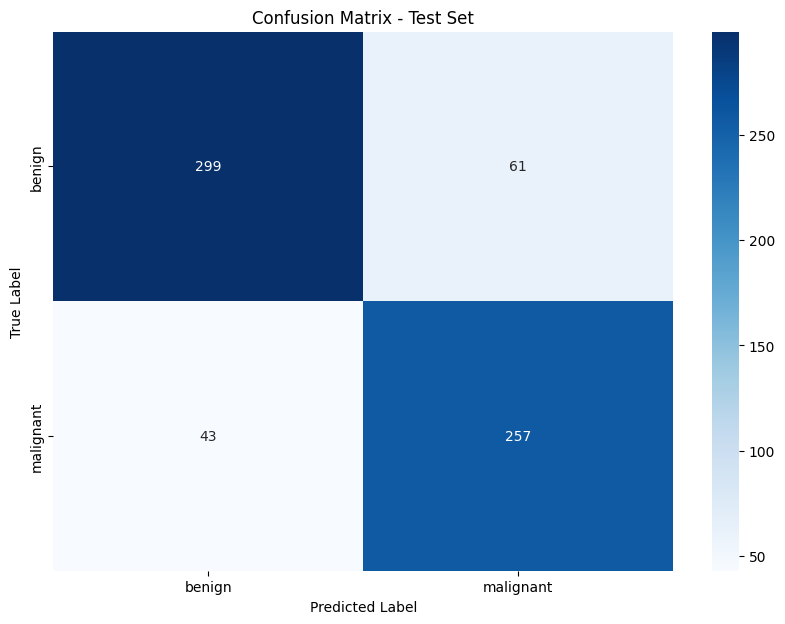

Accuracy: 0.84
Precision: 0.84
Recall: 0.84
F1 score: 0.84
Specificity: 0.83


In [3]:
# Import necessary libraries
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Define directories for train and test data
train_dir = '/content/drive/MyDrive/Small_skin/train'
test_dir = '/content/drive/MyDrive/Small_skin/test'

# Image parameters
img_height, img_width = 224, 224
batch_size = 32

# Data generators for loading .bmp images
datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='sparse',
    color_mode='rgb',
    shuffle=True
)

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='sparse',
    color_mode='rgb',
    shuffle=False
)

# Load the VGG16 model without the top layer (include_top=False)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
x = base_model.output
x = Flatten()(x)
cnn_model = Model(inputs=base_model.input, outputs=x)


# Function to extract features using the CNN
def extract_features(generator, model):
    features = []
    labels = []
    for batch in generator:
        imgs, lbls = batch
        batch_features = model.predict(imgs)
        features.append(batch_features)
        labels.extend(lbls)
        if len(features) * generator.batch_size >= generator.samples:
            break
    features = np.vstack(features)
    labels = np.array(labels)
    return features, labels

# Extract features from the train and test sets
train_features, train_labels = extract_features(train_generator, cnn_model)
test_features, test_labels = extract_features(test_generator, cnn_model)

# Normalize features
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)
test_features = scaler.transform(test_features)

# Train SVM and Gradient Boosting classifiers
svm_classifier = SVC(kernel='linear', probability=True)
svm_classifier.fit(train_features, train_labels)

gb_classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1)
gb_classifier.fit(train_features, train_labels)

# Function to combine predictions
def combine_predictions(svm_pred, gb_pred):
    combined_pred = np.zeros_like(svm_pred)
    for i in range(len(svm_pred)):
        if svm_pred[i] == gb_pred[i]:
            combined_pred[i] = svm_pred[i]
        else:
            combined_pred[i] = gb_pred[i]
    return combined_pred

# Make predictions on test set
test_svm_pred = svm_classifier.predict(test_features)
test_gb_pred = gb_classifier.predict(test_features)
test_combined_pred = combine_predictions(test_svm_pred, test_gb_pred)

# Evaluate accuracy on test set
test_accuracy = accuracy_score(test_labels, test_combined_pred)
print('Test Accuracy:', test_accuracy * 100)
print(classification_report(test_labels, test_combined_pred))

# Confusion matrix for test set
test_cm = confusion_matrix(test_labels, test_combined_pred)

# Plot confusion matrix as heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_generator.class_indices.keys(), yticklabels=train_generator.class_indices.keys())
plt.title('Confusion Matrix - Test Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Calculate accuracy
accuracy = accuracy_score(test_labels, test_combined_pred)
print(f'Accuracy: {accuracy:.2f}')

# Calculate precision
precision = precision_score(test_labels, test_combined_pred, average='weighted')
print(f'Precision: {precision:.2f}')

# Calculate recall
recall = recall_score(test_labels, test_combined_pred, average='weighted')
print(f'Recall: {recall:.2f}')

# Calculate F1 score
f1 = f1_score(test_labels, test_combined_pred, average='weighted')
print(f'F1 score: {f1:.2f}')

# Calculate specificity
tn, fp, fn, tp = test_cm.ravel()
specificity = tn / (tn + fp)
print(f'Specificity: {specificity:.2f}')